# Example script to regrid CESM2 sea ice concentration to a regular 1$^\circ$x1$^\circ$ grid using xesmf

---

## Initial setup

### Start by loading appropriate packages

In [1]:
import xarray as xr
import numpy as np
import xesmf as xe
import matplotlib.pyplot as plt

### Get historical sea ice concentration data from CESM2 for member r1i1p1f1

In [2]:
direc_i = '/Users/pade7652/Google Drive/CUBoulder/Projects/CESM2/Data/CESM2-CMIP6/' # Change to match the directory where your data is found
ds_i    = xr.open_dataset(direc_i+'siconc_SImon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc',chunks={}) # The 'chunks' option above tells xarray to make this a dask array
print(ds_i)

<xarray.Dataset>
Dimensions:    (d2: 2, ni: 320, nj: 384, nvertices: 4, time: 1980)
Coordinates:
    lat        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: d2, nvertices
Data variables:
    siconc     (time, nj, ni) float32 dask.array<chunksize=(1980, 384, 320), meta=np.ndarray>
    time_bnds  (time, d2) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat_bnds   (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds   (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity

/Users/pade7652/opt/anaconda3/envs/regrid_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


### Rename the coordinate variables to 'lat' and 'lon'

xESMF can only recognize coordinates named 'lon' and 'lat', so if they are named something different 'lat' and 'lon', we need to rename them.

In [3]:
# ds_i = ds_i.rename({'latitude':'lat','longitude':'lon'})
# print(ds_i)

### Select the variable that you want to regrid

For this example, we'll be regridding sea ice concentration ('siconc'). Can also subset for specific years and/or months at this point.

In [4]:
sic = ds_i['siconc']
# sic = ds_i['siconc'].sel({'time':slice('1980-01-01','2000-01-01')})
print(sic)

<xarray.DataArray 'siconc' (time: 1980, nj: 384, ni: 320)>
dask.array<open_dataset-49a09dc33c4112a84ad64670f8eb4236siconc, shape=(1980, 384, 320), dtype=float32, chunksize=(1980, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat      (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon      (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * ni       (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj       (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Area fraction of grid cell covered by sea ice
    description:    Area fraction of grid cell covered by sea ice
    frequency:      mon
    id:             siconc
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    ti

### Plot the raw data

/Users/pade7652/opt/anaconda3/envs/regrid_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


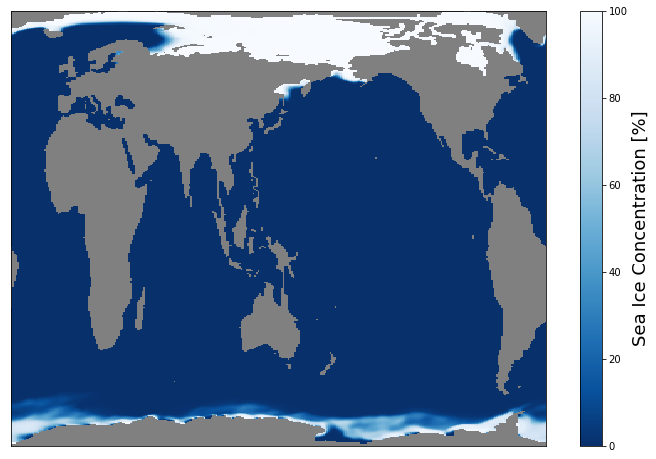

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_facecolor('0.5') # Fill in model land by making the axis background whatever color you want
im1 = ax.pcolormesh(ds_i.coords['ni'],ds_i.coords['nj'],sic[0],cmap='Blues_r',vmin=0,vmax=100)
cbar = plt.colorbar(im1)
cbar.set_label('Sea Ice Concentration [%]',fontsize=18)
plt.xticks([]);
plt.yticks([]);

We can see from the figure above that the data is not on a regular grid since the North Pole is over Greenland.

---

## Change the lat/lon coordinates to use the ones from the ocean

### The lat/lon coordinates in CESM sea ice files have missing values over the land

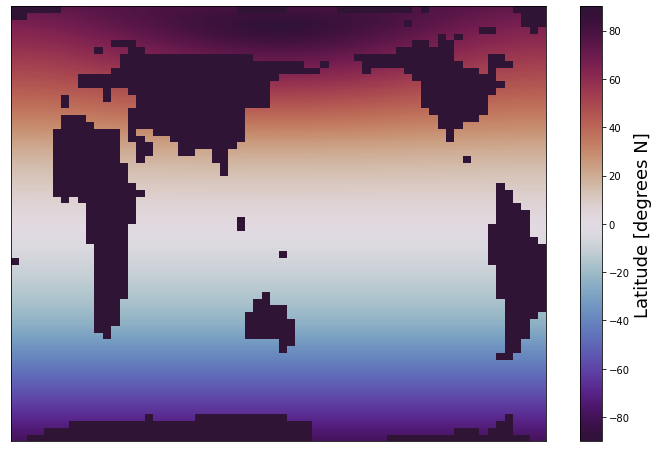

In [6]:
plt.figure(figsize=(12,8))
im2 = plt.pcolormesh(ds_i.coords['lat'],cmap='twilight_shifted',vmin=-90,vmax=90);
cbar = plt.colorbar(im2)
cbar.set_label('Latitude [degrees N]',fontsize=18)
plt.xticks([]);
plt.yticks([]);

The continents have values of 9.96920997e+36 (missing value).

### Read in the lat/lon coordinates from an ocean file, which has no missing values over land

In [7]:
ds_ocean = xr.open_dataset(direc_i+'areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc',chunks={}) # The 'chunks' option above tells xarray to make this a dask array
# Rename the dimensions to match the dimensions of the sea ice file
ds_ocean = ds_ocean.rename({'nlat':'nj','nlon':'ni'})
ds_ocean

/Users/pade7652/opt/anaconda3/envs/regrid_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


<xarray.Dataset>
Dimensions:    (ni: 320, nj: 384, vertices: 4)
Coordinates:
    lat        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
Dimensions without coordinates: vertices
Data variables:
    areacello  (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bnds   (nj, ni, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds   (nj, ni, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                15
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-17T00:41:10Z
    ...                     ...
    sub_experiment:         none
    sub_experiment_id:      none
    branch_time_in_parent:  219000.0
    branch_time_in_child:   674885.0
    branch_method:          standard
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.h...

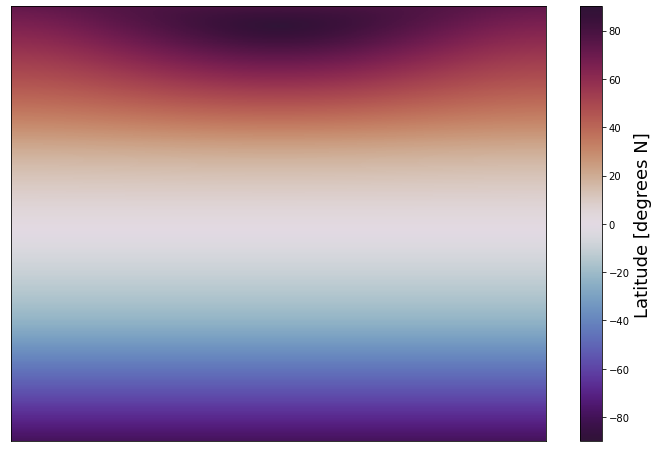

In [8]:
plt.figure(figsize=(12,8))
im3 = plt.pcolormesh(ds_ocean.coords['lat'],cmap='twilight_shifted',vmin=-90,vmax=90);
cbar = plt.colorbar(im3)
cbar.set_label('Latitude [degrees N]',fontsize=18)
plt.xticks([]);
plt.yticks([]);

Now, the lat/lon fields are smooth and don't have any missing values.

### Create a new dataset with the sea ice concentration and the lat/lon coordinates from the ocean file

In [9]:
ds_siconc_ocean               = xr.Dataset()
ds_siconc_ocean['siconc']     = (('time','nj','ni'),sic)
ds_siconc_ocean.coords['lat'] = (('nj','ni'),ds_ocean['lat'])
ds_siconc_ocean.coords['lon'] = (('nj','ni'),ds_ocean['lon'])
sic_ocean                     = ds_siconc_ocean['siconc']

---

## Set up the regridder

### Define the target grid (the new grid you want your output on)

In [10]:
# In this case, we want to regrid to a 1 deg lat x 1 deg lon grid
lat = np.arange(-89.0,90.0,1.0) # Do not include 90S and 90N, it won't work because of the singularity at the poles
lon = np.arange(0.0,361.0,1.0) # cartopy gets rage-y (i.e. it doesn't work) when plotting
lon2d,lat2d = np.meshgrid(lon,lat)
target_grid = xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})
target_grid

# This is another way to set up the target grid using built-in functions from xesmf
# target_grid_new = xe.util.grid_global(0.5,0.5)
# target_grid_new

<xarray.Dataset>
Dimensions:  (x: 361, y: 179)
Dimensions without coordinates: x, y
Data variables:
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon      (y, x) float64 0.0 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0

### Create regridding function

In [11]:
# Possible regridding algorithms. For a comparison of the different algorithms, check out: https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html
method_list = ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']
# NOTE: Once you have the output of this (the weight file), you can set reuse_weights=True so that you don't need to recreate the weight file
regridder = xe.Regridder(sic_ocean, target_grid, method_list[2], periodic=True)

/Users/pade7652/opt/anaconda3/envs/regrid_env/lib/python3.7/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


### Perform regridding

In [12]:
sic_rg = regridder(sic_ocean)
sic_rg

/Users/pade7652/opt/anaconda3/envs/regrid_env/lib/python3.7/site-packages/xesmf/frontend.py:478: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


<xarray.DataArray 'siconc' (time: 1980, y: 179, x: 361)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.65435028, 99.65435028, 99.65435028, ..., 99.63287354,
         99.65435028, 99.65435028],
        [99.75475311, 99.75475311, 99.75475311, ..., 99.75475311,
         99.75475311, 99.75475311],
        [99.78426361, 99.77059937, 99.77059937, ..., 99.78426361,
         99.78426361, 99.78426361]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [99.88413239, 99.88413239, 99.88413239, ..., 99.8852005 ,
         99.88413239, 99.88413239],
        [99.8714447 , 99.8714447 , 99.8714447 , ..., 99.8714447 ,
         99.8714447 , 99.8714447 ],
        [99.84216309, 99.83854675, 99.83854675, ..., 99.84216309,
         99.84216309, 99.84216309]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.93615723, 99.93615723, 99.93615723, ..., 99.94313812,
         99.93615723, 99.93615723],
        [99.9491806 , 99.9491806 , 99.9491806 , ..., 99.9491806 ,
         99.9491806 , 99.9491806 ],
        [99.93619537, 99.93518829, 99.93518829, ..., 99.93619537,
         99.93619537, 99.93619537]]])
Coordinates:
    lon      (y, x) float64 0.0 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
Dimensions without coordinates: time, y, x
Attributes:
    regrid_method:  nearest_s2d

---

## Plot regridded data

/Users/pade7652/opt/anaconda3/envs/regrid_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


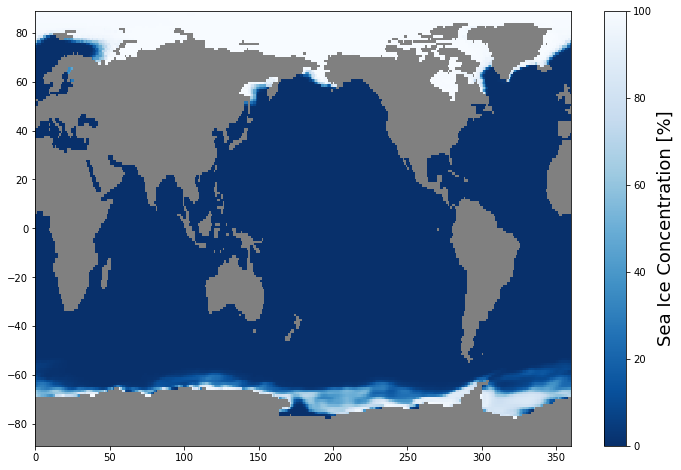

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_facecolor('0.5') # Fill in model land by making the axis background whatever color you want
im4 = ax.pcolormesh(lon,lat,sic_rg[0],cmap='Blues_r',vmin=0,vmax=100)
cbar = plt.colorbar(im4)
cbar.set_label('Sea Ice Concentration [%]',fontsize=18)
# plt.xticks([]);
# plt.yticks([]);

---

## Save regridded data as a netCDF file

### Create output dataset

In [14]:
ds_o = xr.Dataset()
ds_o['siconc']      = (('time','y','x'),sic_rg)
ds_o.coords['lat']  = (('y','x'),sic_rg['lat'])
ds_o.coords['lon']  = (('y','x'),sic_rg['lon'])
ds_o.coords['time'] = (('time'),sic_rg['time'])

### Add attributes to document the output file

In [15]:
ds_o['siconc'].attrs['long_name'] = 'Sea Ice Concentration'
ds_o['siconc'].attrs['units']     = '%'
ds_o.attrs['model']               = 'CESM2'
ds_o.attrs['Description']         = 'historical siconc r1i1p1f1 regridded onto a rectilinear 1.0deg lat x 1.0deg lon grid'

### Set the missing and fill values to whatever they are in the original data

In [16]:
ds_o['siconc'].encoding['_FillValue']    = ds_i['siconc'].encoding['_FillValue']
ds_o['siconc'].encoding['missing_value'] = ds_i['siconc'].encoding['missing_value']

### Save as netCDF file

In [17]:
svdirec = '../Data/'
ds_o.to_netcdf(path=svdirec+'CESM2_siconc_hist_r1i1p1f1_xesmf_rg_1x1.nc')